## Data Preparation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [3]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

In [4]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [5]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

Shape of Final Dataframe = (4255, 5)


In [6]:
scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

In [7]:
def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power', 'fan_speed']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

## Modeling

In [8]:
import torch
import torch.nn as nn

class DualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dense_hidden_size, k_step, fan_speed_impact_dim=32):
        super(DualInputAttentionLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.k_step = k_step
        self.input_size = input_size

        # LSTM and Attention for History
        self.lstm_attention = nn.MultiheadAttention(lstm_hidden_size, num_heads=1, batch_first=True)
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, batch_first=True)

        # LSTM for Fan Speed
        self.fan_speed_lstm = nn.LSTM(1, lstm_hidden_size, batch_first=True)

        # Fully connected layers
        self.dense1 = nn.Linear(lstm_hidden_size * 2, dense_hidden_size)  
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_hidden_size, k_step)

    def forward(self, x, fan_speed):
        batch_size, seq_len, feature_dim = x.shape

        # ====== LSTM Processing for Historical Features ======
        h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        lstm_out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        attn_output, _ = self.lstm_attention(lstm_out, lstm_out, lstm_out)
        lstm_features = attn_output[:, -1, :]  # (batch_size, lstm_hidden_size)

        # # ====== Batch-wise Scaling of Fan Speed ======
        # fan_speed_mean = fan_speed.mean(dim=1, keepdim=True)  # Mean for each batch
        # fan_speed_std = fan_speed.std(dim=1, keepdim=True) + 1e-5  # Prevent division by zero
        # fan_speed_scaled = (fan_speed - fan_speed_mean) / fan_speed_std  # Normalize within batch

        fan_speed_scaled = -fan_speed
        # fan_speed_scaled = -torch.log(fan_speed + 1e-3)

        # ====== LSTM Processing for Fan Speed ======
        fan_h_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        fan_c_t = torch.zeros(1, batch_size, self.lstm_hidden_size, device=x.device)
        fan_lstm_out, (fan_h_t, fan_c_t) = self.fan_speed_lstm(fan_speed_scaled, (fan_h_t, fan_c_t))
        fan_features = fan_lstm_out[:, -1, :]  # Extract last time step

        # ====== Combine Features (Weighted Concatenation) ======
        # alpha = 15 
        alpha = 15
        combined_features = torch.cat((lstm_features, alpha * fan_features), dim=1)  

        # ====== Fully Connected Layers ======
        dense1_out = self.relu(self.dense1(combined_features))
        outputs = self.dense2(dense1_out)

        return outputs


In [9]:
import torch
import torch.optim as optim
import torch.nn as nn

def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 5 epochs

    history = {'train_loss': [], 'test_loss': []}

    # Function to compute loss
    def evaluate_loss(loader, model):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_features, batch_exogenous, batch_outputs in loader:
                outputs = model(batch_features, batch_exogenous)  # Pass full fan speed sequence
                loss = criterion(outputs, batch_outputs.squeeze(-1))  # Ensure correct shape
                total_loss += loss.item()
        return total_loss / len(loader)

    # Compute initial loss before training
    train_loss = evaluate_loss(train_loader, model)
    test_loss = evaluate_loss(test_loader, model)

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_exogenous, batch_outputs in train_loader:
            optimizer.zero_grad()
            
            outputs = model(batch_features, batch_exogenous)  # Pass full fan speed sequence
            loss = criterion(outputs, batch_outputs.squeeze(-1))  # Ensure correct shape
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluate test loss
        test_loss = evaluate_loss(test_loader, model)
        history['test_loss'].append(test_loss)

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, history


In [10]:
torch.manual_seed(42)
np.random.seed(42)

seq_length = 30
k_step = 15
input_size = 4  # cpu_temp, inlet_temp, it_power
lstm_hidden_size = 64
dense_hidden_size = 64
learning_rate = 0.001
num_epochs = 25

In [11]:
train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)
model = DualInputAttentionLSTM(input_size, lstm_hidden_size, dense_hidden_size, k_step)
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 0.4499, Test Loss: 0.1993
Epoch 1/25, Train Loss: 0.0497, Test Loss: 0.0083
Epoch 2/25, Train Loss: 0.0042, Test Loss: 0.0054
Epoch 3/25, Train Loss: 0.0039, Test Loss: 0.0041
Epoch 4/25, Train Loss: 0.0036, Test Loss: 0.0038
Epoch 5/25, Train Loss: 0.0037, Test Loss: 0.0036
Epoch 6/25, Train Loss: 0.0033, Test Loss: 0.0036
Epoch 7/25, Train Loss: 0.0035, Test Loss: 0.0040
Epoch 8/25, Train Loss: 0.0032, Test Loss: 0.0037
Epoch 9/25, Train Loss: 0.0031, Test Loss: 0.0034
Epoch 10/25, Train Loss: 0.0031, Test Loss: 0.0034
Epoch 11/25, Train Loss: 0.0029, Test Loss: 0.0036
Epoch 12/25, Train Loss: 0.0029, Test Loss: 0.0034
Epoch 13/25, Train Loss: 0.0030, Test Loss: 0.0035
Epoch 14/25, Train Loss: 0.0030, Test Loss: 0.0034
Epoch 15/25, Train Loss: 0.0029, Test Loss: 0.0034
Epoch 16/25, Train Loss: 0.0029, Test Loss: 0.0034
Epoch 17/25, Train Loss: 0.0029, Test Loss: 0.0033
Epoch 18/25, Train Loss: 0.0028, Test Loss: 0.0034
Epoch 19/25, Train Loss: 0.0029, Tes

## Forecast Verification

In [20]:
def forecast_with_modified_exogenous(model, test_loader, scaler, k_step, modified_fan_speed):
    model.eval()

    fan_speeds = []
    for fs in modified_fan_speed:
        fan_speeds.append(scalers["fan_speed"].inverse_transform(np.array([fs]).reshape(-1, 1)).flatten()[0])

    print(f"Modified Fan Speeds: {fan_speeds}")
    
    # Get a single sample from the test loader
    batch_features, batch_exogenous, batch_outputs = next(iter(test_loader))

    # Use only the first sample in the batch
    features = batch_features[0].unsqueeze(0)  # Shape: [1, seq_length, input_size]
    exogenous = batch_exogenous[0].unsqueeze(0)  # Shape: [1, k_step, 1]
    
    # Modify the exogenous input (fan speed)
    modified_inputs = []
    for fan_speed in modified_fan_speed:
        modified_exogenous = torch.full_like(exogenous, fan_speed)
        modified_inputs.append(modified_exogenous)

    print(f"Original Exogenous Input (Fan Speed): {exogenous.flatten().cpu().numpy()}")

    modified_forecasts = []
    for modified_exogenous in modified_inputs:
        with torch.no_grad():
            forecast = model(features, modified_exogenous).cpu().numpy().flatten()
            modified_forecasts.append(forecast)
    with torch.no_grad():
        # Forecast using the original exogenous input
        original_forecast = model(features, exogenous).cpu().numpy().flatten()

    # Get actual values for comparison
    actual_values = batch_outputs[0].cpu().numpy().flatten()

    original_forecast = scaler.inverse_transform(original_forecast.reshape(-1, 1)).flatten()
    for i, forecast in enumerate(modified_forecasts):
        modified_forecasts[i] = scaler.inverse_transform(forecast.reshape(-1, 1)).flatten()
    actual_values = scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, k_step+1), actual_values, linestyle='-', label='Actual CPU Temp', color='black')
    plt.plot(range(1, k_step+1), original_forecast, linestyle='--', label='Original Forecast', color='blue')
    for i, modified_forecast in enumerate(modified_forecasts):
        plt.plot(range(1, k_step+1), modified_forecast, linestyle='--', label=f'Forecast with Fan Speed={round(fan_speeds[i], 0)} rpm')

    plt.xlabel("Time Steps")
    plt.ylabel("CPU Temperature")
    plt.title("Forecast Comparison with Modified Input (Fan Speed)")
    plt.ylim(45, 55) 
    plt.legend()
    plt.show()


Modified Fan Speeds: [np.float64(3815.4918976604176), np.float64(3882.485334541852), np.float64(4636.161499457989), np.float64(5473.5794604759185)]
Original Exogenous Input (Fan Speed): [0.05131203 0.0514401  0.0514722  0.05139478 0.05139478 0.05139478
 0.05139478 0.05139478 0.05120784 0.05120784 0.05091139 0.05091139
 0.05091139 0.05091139 0.05050541]


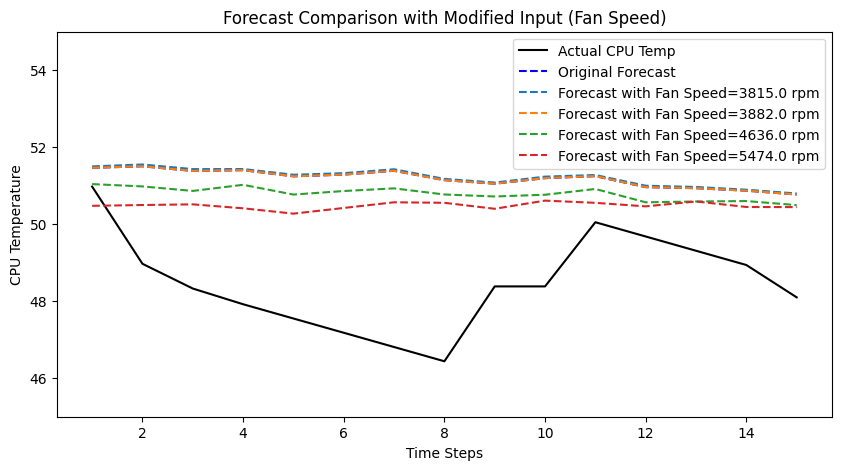

In [21]:
forecast_with_modified_exogenous(trained_model, test_loader, scalers["cpu_temp"], k_step, modified_fan_speed=[ 0.01, 0.05, 0.5, 1])

In [ ]:
# 1. Trend is captured in the fan speed range of 0 to 1 (after min max scaling)
# 2. The model however is less sensitive to changes in fan speed
# 3. The model produces more fluctuating results in the range outside of 0 to 1. This maybe because the model has not seen such values during training.

## Goal:
# To make the model more sensitive to changes in fan speed.
# To capture the trend outside the range of 0 to 1.
# Energy computation theory background

## Model Evaluation

In [22]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score

def evaluate_model(model, test_loader, scaler, df, k_step, split_index):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:

            outputs = model(batch_features, batch_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(2))  # Ensure matching dimensions
            test_loss += loss.item()

            predictions.append(outputs.cpu().numpy())  # Move to CPU before converting to NumPy
            actuals.append(batch_outputs.cpu().numpy())

    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy arrays
    predictions = np.concatenate(predictions, axis=0)  # Shape: (num_samples, k_step)
    actuals = np.concatenate(actuals, axis=0)  # Shape: (num_samples, k_step, 1)

    # Flatten actuals to (num_samples, k_step)
    actuals = actuals.squeeze(axis=2)

    # Create a dataframe using the original dataframe index
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:, i]

    # Create a dataframe from predictions using the same index
    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}'] = predictions[:, i]

    # Inverse scale the predicted and actual values
    for i in range(k_step):
        original_data = scaler.inverse_transform(
            predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}']].values
        )
        predictions_df[f'predicted_cpu_temp_{i+1}'] = original_data[:, -1]

        original_data_actual = scaler.inverse_transform(
            actual_df[['cpu_temp', 'inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values
        )
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:, -1]

    predictions_df.reset_index(inplace=True)

    # Calculate R2 scores
    r2_scores = []
    for i in range(k_step):
        r2 = r2_score(predictions_df[f'actual_cpu_temp_{i+1}'], predictions_df[f'predicted_cpu_temp_{i+1}'])
        r2_scores.append(r2)
        print(f"R2 Score for Step {i+1}: {r2:.4f}")
    average_r2 = np.mean(r2_scores)
    print(f"Average R2 Score: {average_r2:.4f}")

    # Calculate RMSE scores
    rmse_scores = []
    for i in range(k_step):
        mse = np.mean((predictions_df[f'actual_cpu_temp_{i+1}'] - predictions_df[f'predicted_cpu_temp_{i+1}']) ** 2)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        print(f"RMSE for Step {i+1}: {rmse:.4f}")
    average_rmse = np.mean(rmse_scores)
    print(f"Average RMSE: {average_rmse:.4f}")

    return predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse


In [23]:
def evaluate_model_modified(model, test_loader, scaler, df, k_step, split_index, modified_fan_speed):
    model.eval()
    criterion = nn.MSELoss()
    test_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_features, batch_exogenous, batch_outputs in test_loader:
            actuals.append(batch_outputs.cpu().numpy())
            # modified_exogenous = torch.full_like(batch_exogenous, modified_fan_speed)
            modified_exogenous = batch_exogenous * modified_fan_speed
            outputs = model(batch_features, modified_exogenous)
            loss = criterion(outputs, batch_outputs.squeeze(2))
            test_loss += loss.item()
            predictions.append(outputs.cpu().numpy())
    
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

    # Convert predictions and actuals to numpy arrays
    actuals = np.concatenate(actuals, axis=0).squeeze(axis=2)
    predictions = np.concatenate(predictions, axis=0)

    # Create dataframe
    actual_df = df.iloc[split_index:split_index + len(actuals)].copy()
    for i in range(k_step):
        actual_df[f'actual_cpu_temp_{i+1}'] = actuals[:, i]

    predictions_df = actual_df.copy()
    for i in range(k_step):
        predictions_df[f'predicted_cpu_temp_{i+1}_fan_{modified_fan_speed}'] = predictions[:, i]

    # Inverse transform values
    for i in range(k_step):
        original_data = scaler.inverse_transform(
            predictions_df[['cpu_temp', 'inlet_temp', 'it_power', f'predicted_cpu_temp_{i+1}_fan_{modified_fan_speed}']].values
        )
        predictions_df[f'predicted_cpu_temp_{i+1}_fan_{modified_fan_speed}'] = original_data[:, -1]

        original_data_actual = scaler.inverse_transform(
            actual_df[['cpu_temp', 'inlet_temp', 'it_power', f'actual_cpu_temp_{i+1}']].values
        )
        predictions_df[f'actual_cpu_temp_{i+1}'] = original_data_actual[:, -1]

    predictions_df.reset_index(inplace=True)
    
    return predictions_df, test_loss

In [27]:
def plot_results(predictions_df, predictions_df_modified, k_step, r2_scores, modified_fan_speed):
    for i in range(k_step):
        plt.figure(figsize=(12, 6))
        # plt.plot(predictions_df_modified[f'predicted_cpu_temp_{i+1}_fan_{modified_fan_speed}'], label=f'Predicted CPU Temp {i+1} (Fan={modified_fan_speed})', color='red')
        plt.plot(predictions_df[f'predicted_cpu_temp_{i+1}'], label=f'Predicted CPU Temp {i+1}', color='red')
        plt.plot(predictions_df[f'actual_cpu_temp_{i+1}'], label=f'Actual CPU Temp {i+1}', color='blue', alpha=0.6)

        plt.xlabel('Time Step', fontsize=14)
        plt.ylabel('CPU Temperature (°C)', fontsize=14)
        plt.title(f'Predicted vs Actual CPU Temperature - Step {i+1}, Fan Speed={modified_fan_speed}, R²: {r2_scores[i]:.4f}', fontsize=16)
        plt.legend(fontsize=12)
        plt.show()

In [28]:
# Define modified fan speed values for testing
modified_fan_speed_values = 0.05

predictions_df, test_loss, r2_scores, rmse_scores, average_r2, average_rmse = evaluate_model(
    trained_model, test_loader, scalers["cpu_temp"], combined_df, k_step, split_index
)

# Call evaluate_model function
predictions_df_modified, test_loss_modified = evaluate_model_modified(
    model=trained_model,
    test_loader=test_loader,
    scaler=scalers['cpu_temp'],
    df=combined_df,
    k_step=k_step,
    split_index=split_index,
    modified_fan_speed=modified_fan_speed_values
)


Test Loss: 0.0033
R2 Score for Step 1: 0.9627
R2 Score for Step 2: 0.9615
R2 Score for Step 3: 0.9618
R2 Score for Step 4: 0.9632
R2 Score for Step 5: 0.9614
R2 Score for Step 6: 0.9639
R2 Score for Step 7: 0.9649
R2 Score for Step 8: 0.9634
R2 Score for Step 9: 0.9658
R2 Score for Step 10: 0.9668
R2 Score for Step 11: 0.9670
R2 Score for Step 12: 0.9677
R2 Score for Step 13: 0.9667
R2 Score for Step 14: 0.9669
R2 Score for Step 15: 0.9656
Average R2 Score: 0.9646
RMSE for Step 1: 1.6975
RMSE for Step 2: 1.7272
RMSE for Step 3: 1.7237
RMSE for Step 4: 1.6943
RMSE for Step 5: 1.7381
RMSE for Step 6: 1.6836
RMSE for Step 7: 1.6639
RMSE for Step 8: 1.7018
RMSE for Step 9: 1.6468
RMSE for Step 10: 1.6255
RMSE for Step 11: 1.6249
RMSE for Step 12: 1.6114
RMSE for Step 13: 1.6386
RMSE for Step 14: 1.6384
RMSE for Step 15: 1.6720
Average RMSE: 1.6725
Test Loss: 0.0033


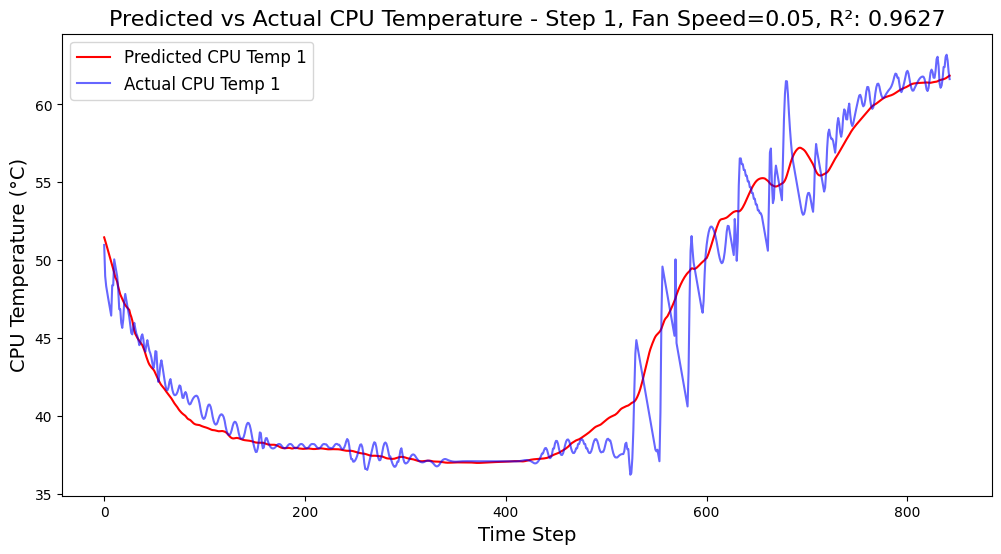

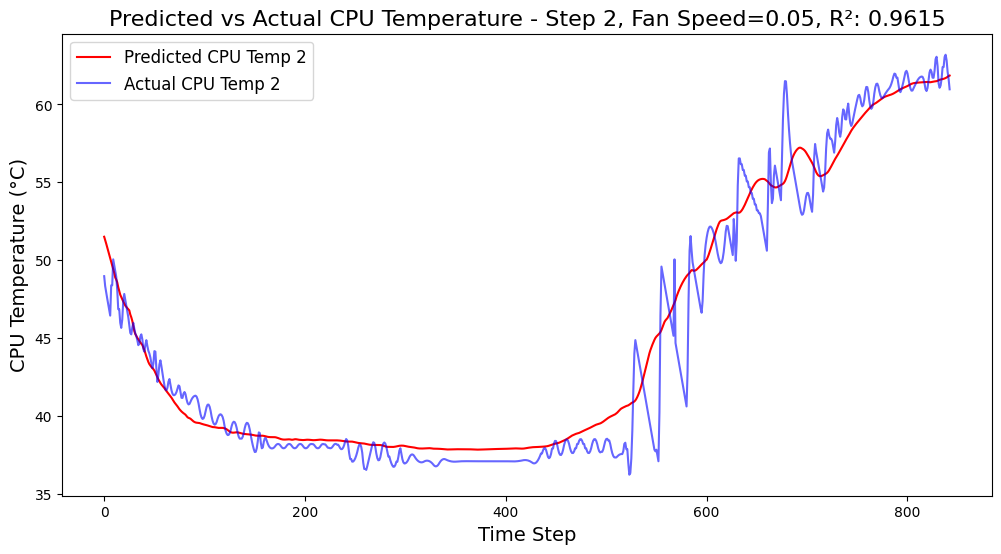

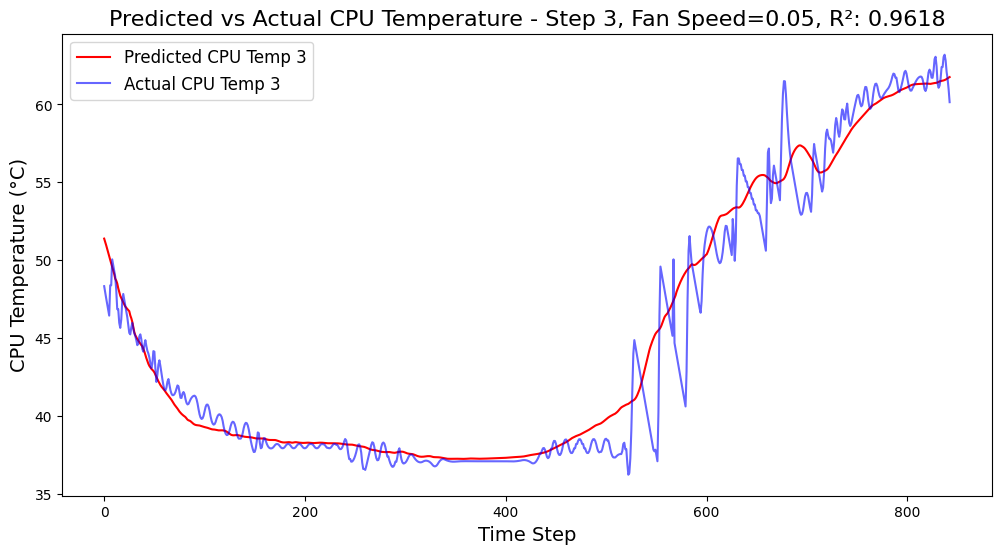

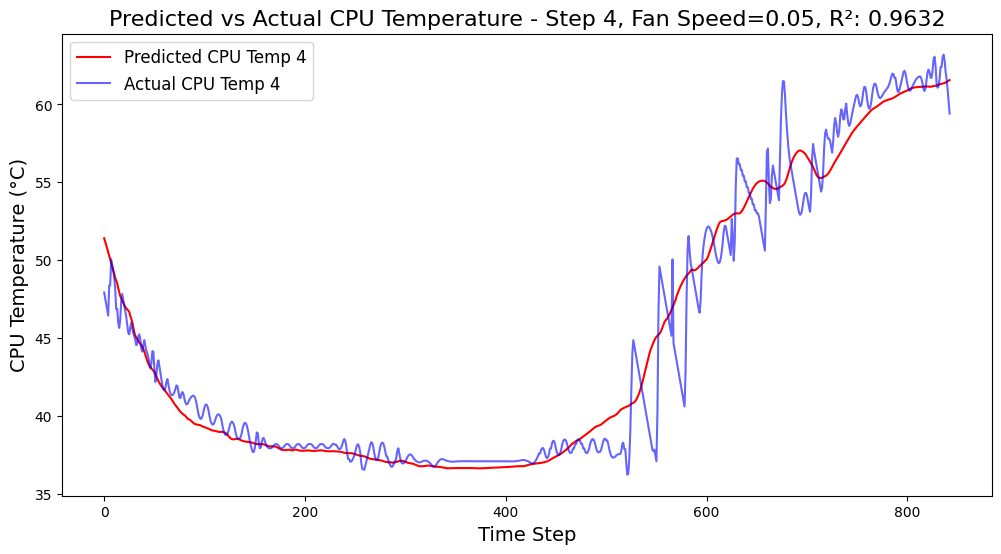

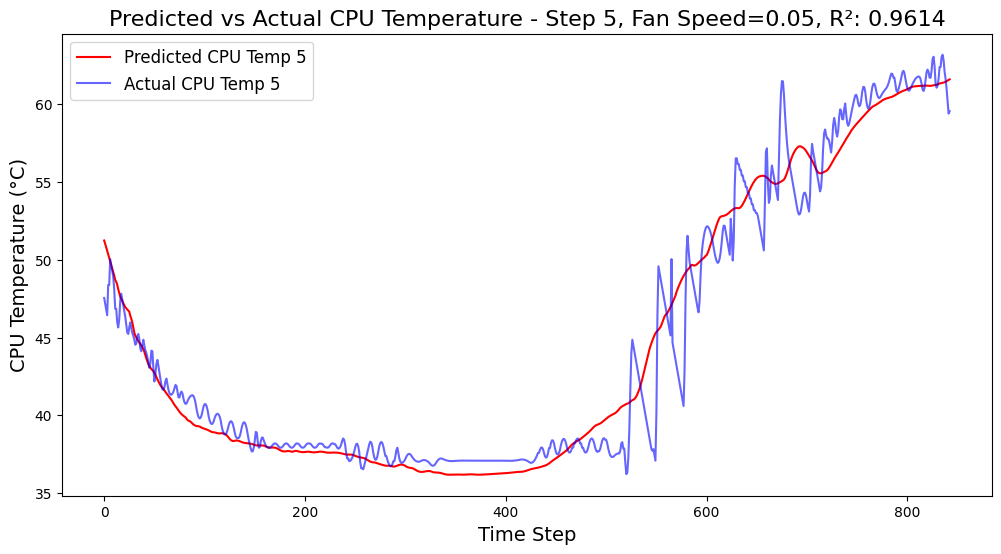

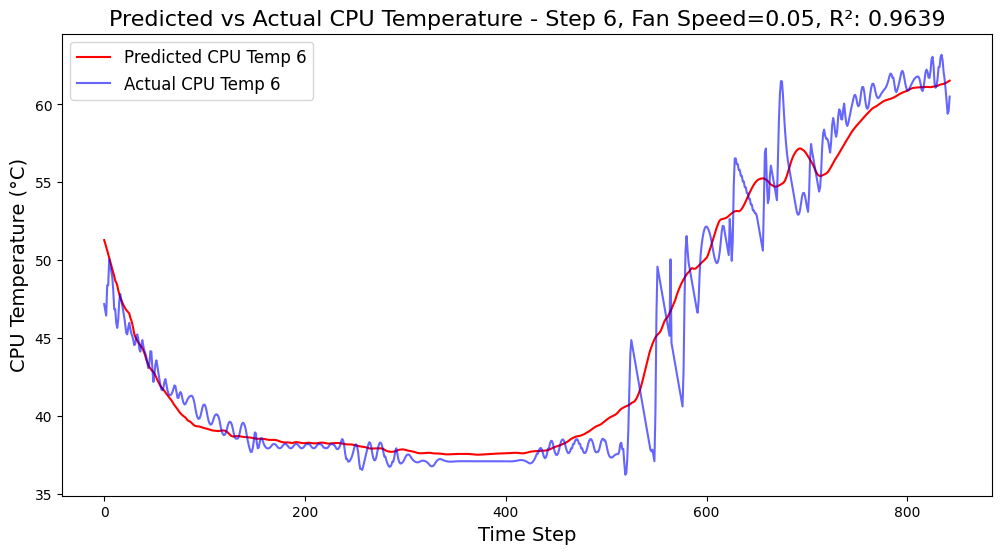

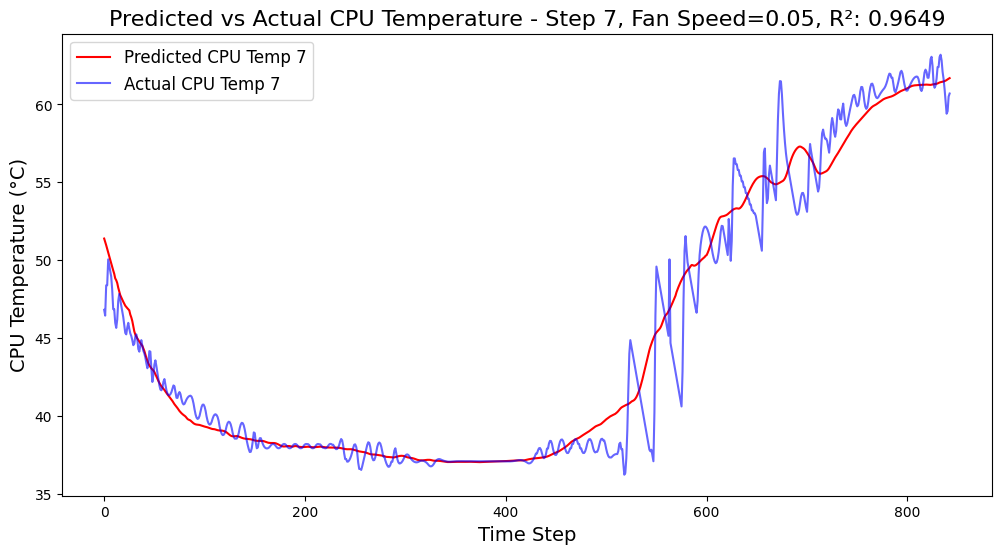

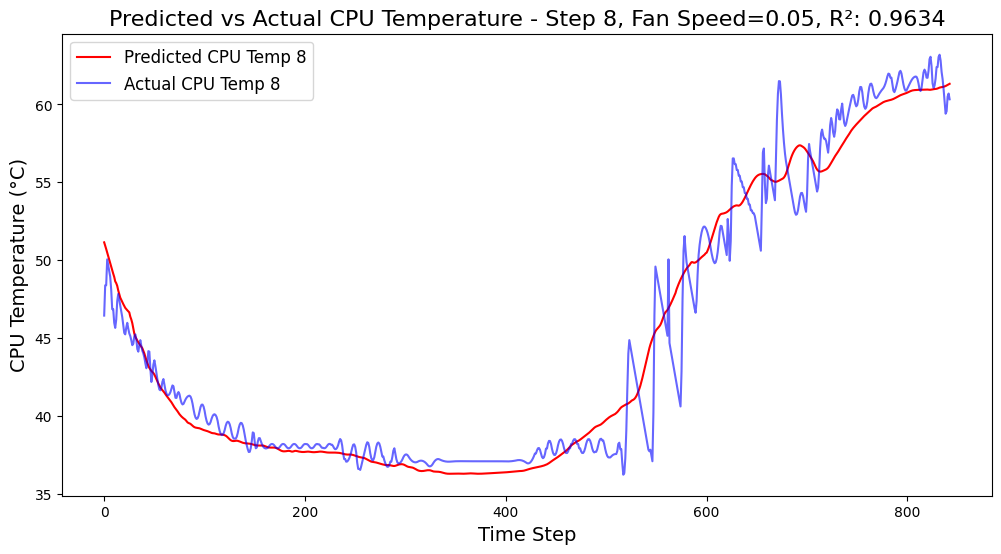

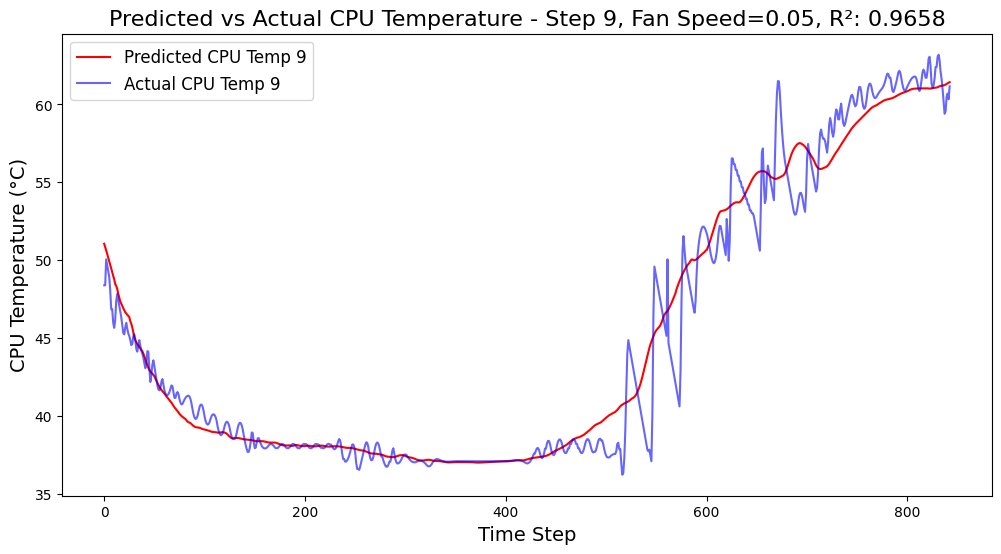

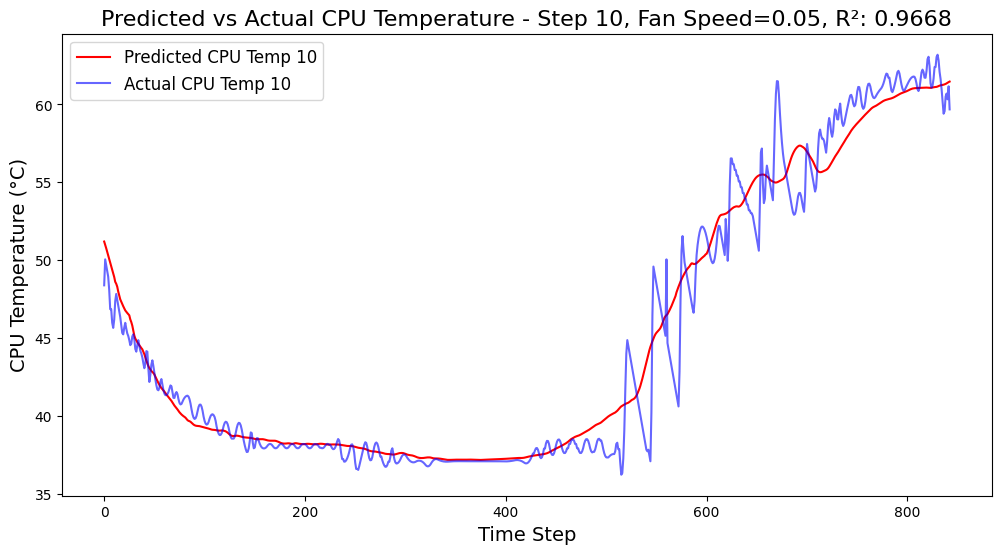

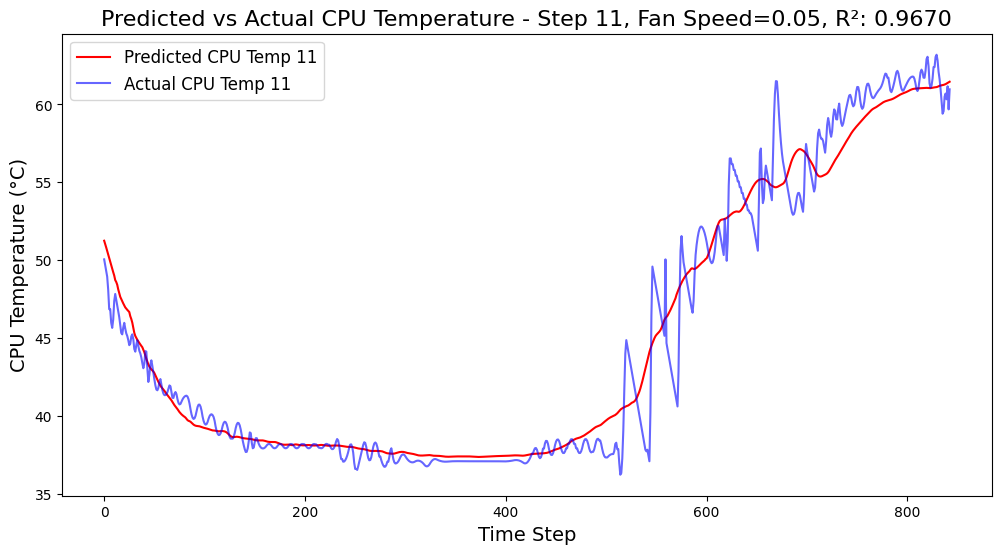

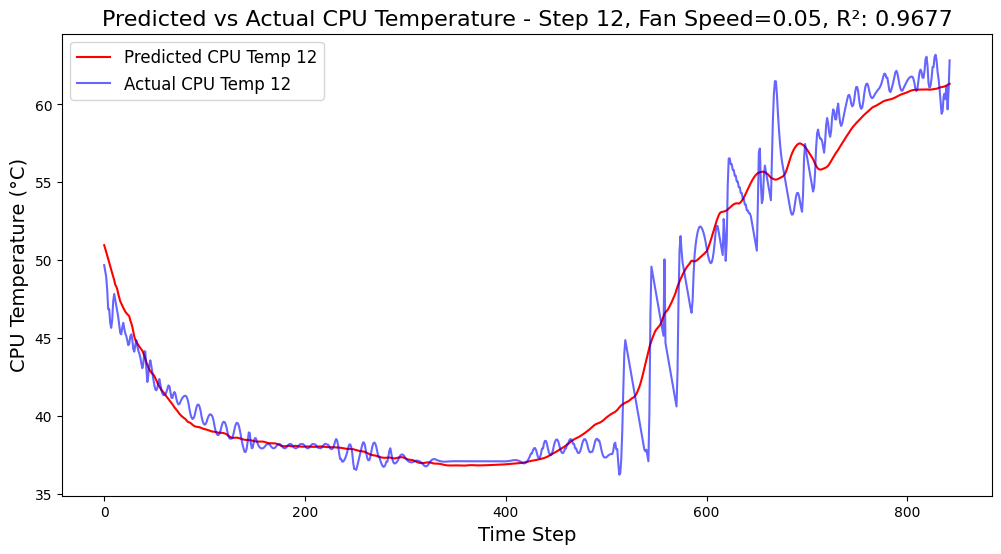

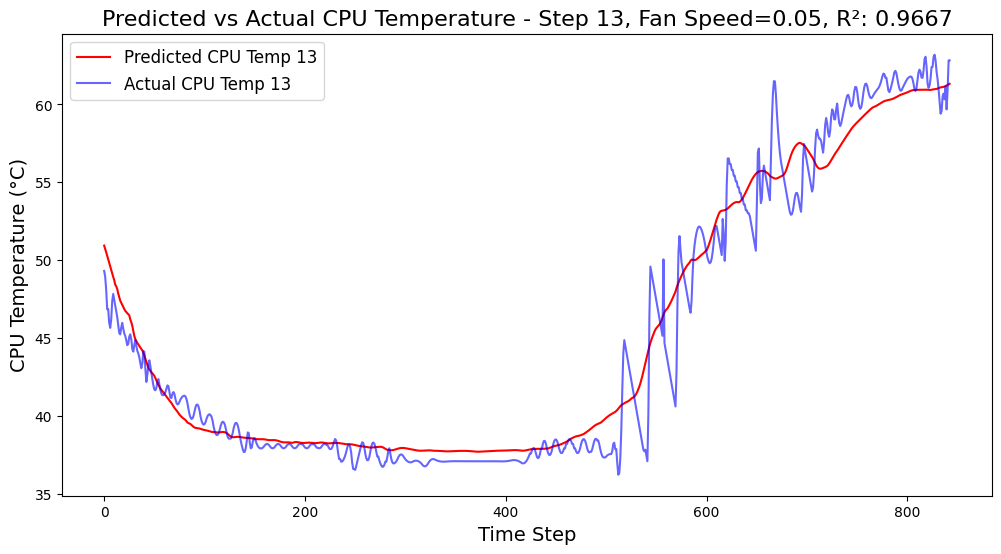

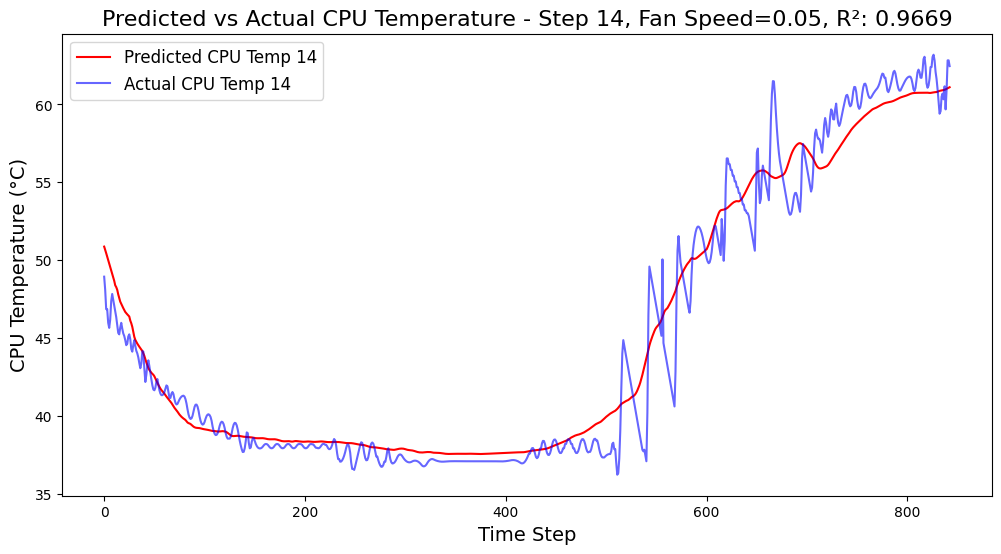

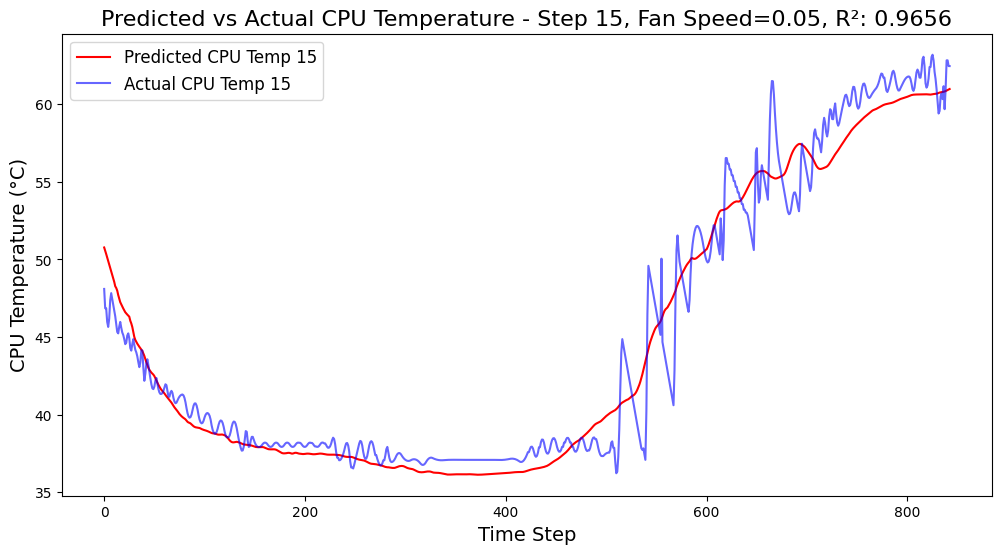

In [29]:
plot_results(predictions_df, predictions_df_modified, k_step, r2_scores, modified_fan_speed_values)